In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as gnn
import pickle
from tqdm import tqdm
import numpy as np
from torch.functional import F
import matplotlib.pyplot as plt


with open("data/train_graphs_data.pkl", "rb") as file:
    graphs = pickle.load(file)
    file.close()

In [164]:
len(graphs), graphs[0]

(90,
 Data(x=[1140, 33], edge_index=[2, 11709], edge_attr=[11709, 2], y=[1140, 2]))

In [165]:
graphs[0].y[0]

tensor([-0.2741, -0.6940])

In [166]:
# 划分训练集和验证集，使用sklearn的train_test_split函数
from sklearn.model_selection import train_test_split

train_graphs, val_graphs = train_test_split(graphs, test_size=0.1)

In [167]:
class SAGEModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SAGEModel, self).__init__()

        self.graph_features = nn.ModuleList(
            [
                gnn.SAGEConv(input_size, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                gnn.SAGEConv(128, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                gnn.SAGEConv(128, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
            ]
        )

        # 考虑更多的trick，如layernorm等等
        self.regression = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, output_size),
        )

    def forward(self, data):
        x, edge_index, _ = data.x, data.edge_index, data.edge_attr

        output = x

        for layer in self.graph_features:
            if isinstance(layer, gnn.SAGEConv):
                output = layer(output, edge_index)
            else:
                output = layer(output)

        output = self.regression(output)

        return output

In [168]:
# 看看模型的输入输出
model = SAGEModel(input_size=33, output_size=32)
output = model(graphs[0])
output.shape

torch.Size([1140, 32])

### LSTM的输入为一个节点的seq_length天的数据

In [169]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.features = nn.Sequential(
            nn.LSTM(
                input_size=input_size,
                hidden_size=64,
                num_layers=1,
                batch_first=True,
            ),
        )

        self.linears = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        out, (_, _) = self.features(x)
        out = self.linears(out)

        return out

In [170]:
lstm_input = np.array([g.x for g in graphs])
# batch放到第一个维度
lstm_input = lstm_input.swapaxes(0, 1)
lstm_input = torch.from_numpy(lstm_input).float()

lstm_input.shape

torch.Size([1140, 90, 33])

In [171]:
model = LSTMModel(input_size=33, output_size=2)
output = model(lstm_input)
output.shape

torch.Size([1140, 90, 2])

### 制作lstm所需数据

In [172]:
def genLSTMData(graph_x_list, seq_len):
    # graph_x_list.shape = [90张图, 1140个节点, 33个特征]
    print(graph_x_list.shape)
    x_list = graph_x_list.reshape(graph_x_list.shape[0], -1)

    x_seq_list = []
    for i in range(x_list.shape[1] - seq_len):
        x_seq_list.append(x_list[i : i + seq_len, :])
    return x_seq_list

In [173]:
class SAGEandLSTMModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SAGEandLSTMModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.sage = SAGEModel(input_size, 32)
        self.lstm = LSTMModel(32, output_size)

    def forward(self, graphs):
        # data: [graph]
        # 堆叠在维度1
        # output.shape = [1140个节点, 90张图, 32个特征]
        output = torch.stack([self.sage(graph) for graph in graphs], dim=1)
        output = self.lstm(output)

        return output

In [174]:
model = SAGEandLSTMModel(input_size=33, output_size=2)
output = model(graphs)

output.shape

torch.Size([1140, 90, 2])

In [175]:
input_size = graphs[0].x.shape[1]
# 这里的output_size就是最终的输出维度，不需要再乘以num_heads
output_size = graphs[0].y.shape[1]
# 个人认为，注意力头的个数应该和输出维度保持一致，因为每个输出可能需要关注不同的邻居
num_heads = graphs[0].y.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch_size = 256
input_size, output_size, num_heads, device

(33, 2, 2, device(type='cuda'))

# 开始训练

In [176]:
def train(model, criterion, optimizer, train_graphs, val_graphs=None, num_epochs=50):
    # 训练过程记录
    train_loss_list = []
    val_loss_list = []
    train_graphs = [graph.to(device) for graph in train_graphs]

    with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar_epochs:
        for epoch in range(num_epochs):
            # 训练
            model.train()
            train_loss = 0.0

            output = model(train_graphs)

            optimizer.zero_grad()
            loss = criterion(output, torch.stack([graph.y for graph in train_graphs], dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            train_loss /= len(train_graphs)
            train_loss_list.append(train_loss)

            # 验证
            if val_graphs:
                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for i, graph in enumerate(val_graphs):
                        graph = graph.to(device)
                        output = model(graph)
                        loss = criterion(output, graph.y)
                        val_loss += loss.item()
                    val_loss /= len(val_graphs)
                    val_loss_list.append(val_loss)

            if val_graphs:
                pbar_epochs.set_postfix(
                    {"train MSE Loss": train_loss, "val MSE Loss": val_loss}
                )
            else:
                pbar_epochs.set_postfix({"train MSE Loss": train_loss})
            pbar_epochs.update(1)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label="train loss")
    if val_graphs:
        plt.plot(val_loss_list, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.legend()

    return model

Training Progress:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training Progress: 100%|██████████| 300/300 [01:32<00:00,  3.26epoch/s, train MSE Loss=0.00348]


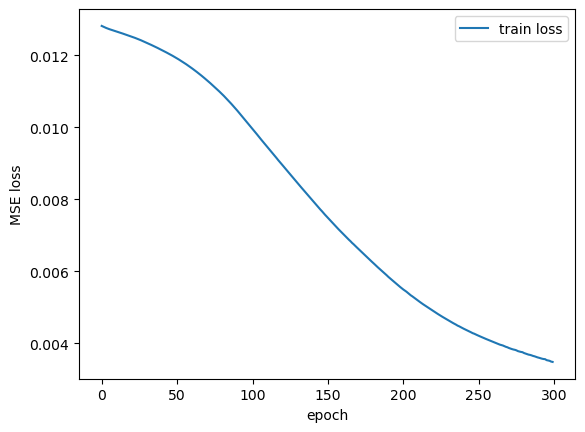

In [177]:
# 定义模型、算法、损失函数
model = SAGEandLSTMModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss(reduction="sum")
criterion = nn.MSELoss().to(device)

model = train(model, criterion, optimizer, train_graphs, num_epochs=300)

### 把所有数据都放进模型训练

Training Progress:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training Progress: 100%|██████████| 300/300 [06:58<00:00,  1.39s/epoch, train MSE Loss=0.0163]


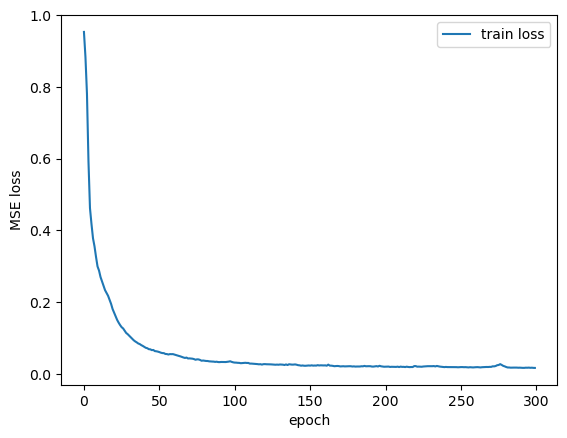

In [10]:
# 定义模型、算法、损失函数
model = GATv2Model(
    input_size=input_size,
    output_size=output_size,
    num_heads=num_heads,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

model = train(model, criterion, optimizer, graphs, num_epochs=300)

In [11]:
# 保存模型
model_path = "saved/models/gatv2.pth"
torch.save(model.state_dict(), model_path)

# 预测

In [12]:
# 读取模型
model = GATv2Model(
    input_size=input_size,
    output_size=output_size,
    num_heads=num_heads,
).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [13]:
# 读取node_ids
with open("data/node_ids.pkl", "rb") as file:
    node_ids = pickle.load(file)
    file.close()

In [14]:
# 读取scaler
import pickle

with open("saved/scaler/label_scaler.pkl", "rb") as file:
    label_scaler = pickle.load(file)
    file.close()

In [15]:
# 读取测试集
with open("data/test_graphs_data.pkl", "rb") as file:
    test_graphs = pickle.load(file)
    file.close()

In [16]:
len(test_graphs), test_graphs[0]

(4, Data(x=[1140, 33], edge_index=[2, 21018], edge_attr=[21018, 2]))

预测

In [17]:
model.eval()
output_list = []
with torch.no_grad():
    for i, graph in enumerate(test_graphs):
        graph = graph.to(device)
        output = model(graph)
        output_list.append(output.detach().cpu().numpy())

In [18]:
len(output_list), output_list[0].shape, output_list[0][0]

(4, (1140, 2), array([-0.4958153, -1.1209753], dtype=float32))

In [19]:
# 缩放
output_list = [label_scaler.inverse_transform(output) for output in output_list]

In [20]:
# 看看是不是缩放完成啦
output_list[0][0]

array([68.54479 , 60.073708], dtype=float32)

### 把输出转成需要的格式

In [21]:
import csv

# 结果写入csv，分隔符为\t
output_path = "output/gatv2_out.csv"

date_id = [20230404, 20230405, 20230406, 20230407]
with open(output_path, "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # 设置分隔符为制表符
    writer.writerow(["geohash_id", "consumption_level", "activity_level", "date_id"])

    # output_list.shape = [4天, 节点数, 2个输出]
    for nidx in range(len(node_ids)):
        for day in range(len(date_id)):
            # 注意不要写反了
            writer.writerow(
                [
                    node_ids[nidx],
                    output_list[day][nidx][1],
                    output_list[day][nidx][0],
                    date_id[day],
                ]
            )
    f.close()